<a href="https://colab.research.google.com/github/Nniichha/229352-StatisticalLearning/blob/main/660510739_Lab05_decision_tree_bagging_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #5

#### Load data at: https://donlapark.pages.dev/229352/heart_disease.csv

* Decision tree ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html))
* Random hyperparameter search using cross-validation ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html))

In [28]:
import pandas as pd
import graphviz

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, f1_score



# import data
data = pd.read_csv("heart_disease.csv", na_values="?")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [29]:

# split into X and y
y = data["label"]
X = data.drop("label", axis=1)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# impute missing values
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Create a decision tree
clf = DecisionTreeClassifier()

![5CV](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [30]:
params = {'max_depth': [3, 6, 9, 12]}

gridcv = GridSearchCV(clf, params, scoring='accuracy', cv=5)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 6, 9, 12]}, scoring='accuracy')

In [31]:
gridcv.best_estimator_

DecisionTreeClassifier(max_depth=3)

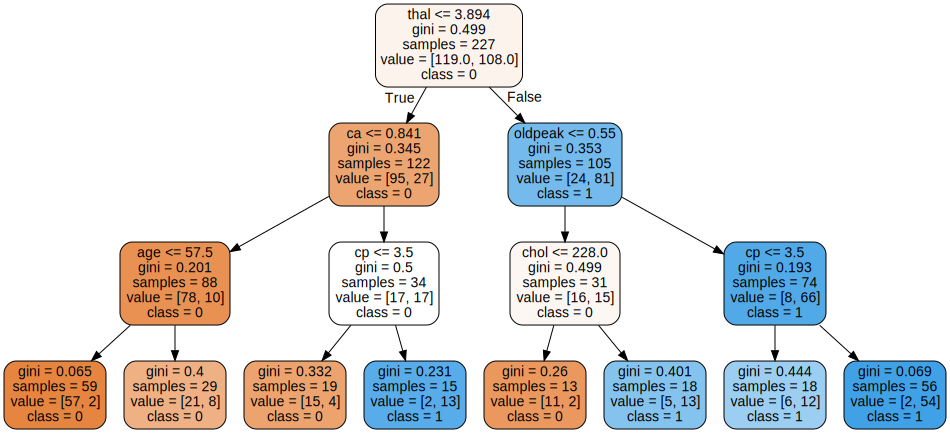

In [32]:
plot_data = export_graphviz(gridcv.best_estimator_,
                            out_file=None,
                            filled=True,
                            rounded=True,
                            feature_names=data.columns[:-1],
                            class_names=['0', '1'])

graph = graphviz.Source(plot_data)
graph

## Bagged decision trees
* Bagging classifier ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html))

In [33]:
clf = DecisionTreeClassifier()

## Random forest classifier
* Random forest ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

#### Exercise
1. Study the hyperparameters of three models: [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Bagged Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. For each model, use pipeline+grid search cross-validation across multiple hyperparameters to find the best model.
* Decision tree: choose at least 3 hyperparameters
* Bagged decision trees: choose at least 3 hyperparameters
* Random forest: choose at least 3 hyperparameters
3. For each model, compute the `f1_macro` and `accuracy` score on the test set.
* What is your best model?
* Plot the best tree model
* What hyperparameters did you choose? (explain in words, not in `sklearn's` parameter name)
* What are the best values of your hyperparameters?

In [34]:
pipe_dt = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "model__max_depth": [3, 6, 9],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5]
}

gs_dt = GridSearchCV(
    pipe_dt,
    param_grid_dt,
    cv=5,
    scoring="f1_macro"
)

gs_dt.fit(X_train, y_train)
dt_best = gs_dt.best_estimator_


In [35]:
y_pred_dt = dt_best.predict(X_test)

dt_acc = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average="macro")

dt_acc, dt_f1


(0.7763157894736842, 0.7695737471018369)

In [36]:
pipe_bag = Pipeline([
    ("scaler", StandardScaler()),
    ("model", BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42
    ))
])

param_grid_bag = {
    "model__n_estimators": [50, 100],
    "model__max_samples": [0.6, 0.8, 1.0],
    "model__estimator__max_depth": [3, 6, None]
}

gs_bag = GridSearchCV(
    pipe_bag,
    param_grid_bag,
    cv=5,
    scoring="f1_macro"
)

gs_bag.fit(X_train, y_train)
bag_best = gs_bag.best_estimator_


In [37]:
y_pred_bag = bag_best.predict(X_test)

bag_acc = accuracy_score(y_test, y_pred_bag)
bag_f1 = f1_score(y_test, y_pred_bag, average="macro")

bag_acc, bag_f1


(0.7763157894736842, 0.7695737471018369)

In [38]:
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, None],
    "model__max_features": ["sqrt", "log2"]
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=5,
    scoring="f1_macro"
)

gs_rf.fit(X_train, y_train)
rf_best = gs_rf.best_estimator_


In [39]:
y_pred_rf = rf_best.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average="macro")

rf_acc, rf_f1


(0.8289473684210527, 0.8199380353562967)

In [40]:
results = pd.DataFrame({
    "Model": ["Decision Tree", "Bagged Trees", "Random Forest"],
    "Accuracy": [dt_acc, bag_acc, rf_acc],
    "F1_macro": [dt_f1, bag_f1, rf_f1]
})

results


,Model,Accuracy,F1_macro
0,Decision Tree,0.776316,0.769574
1,Bagged Trees,0.776316,0.769574
2,Random Forest,0.828947,0.819938


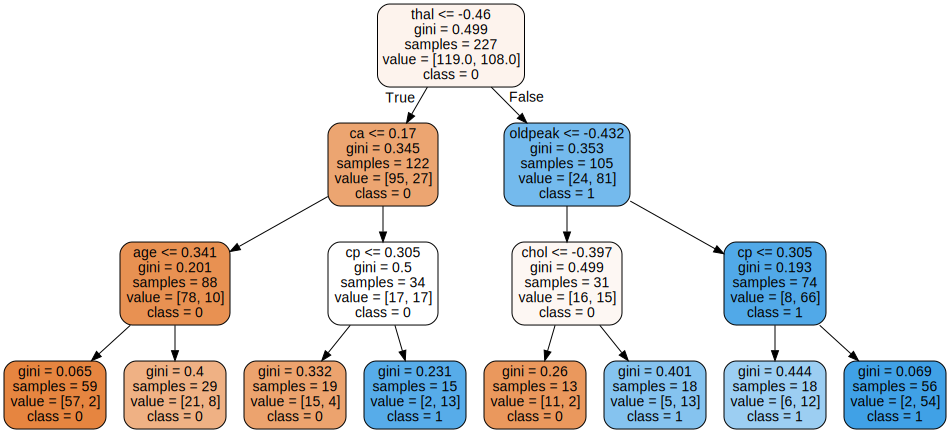

In [41]:
best_tree = dt_best.named_steps["model"]

plot_data = export_graphviz(
    best_tree,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=data.columns[:-1],
    class_names=["0", "1"]
)

graphviz.Source(plot_data)
